In [67]:
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 2

!pip install seaborn as sns
!pip install lxml
import os
import sys
import argparse
import csv
import requests
import time
from bs4 import BeautifulSoup

from concurrent.futures import ThreadPoolExecutor
import collections

import bbscraper.scraper
import pandas as pd

import matplotlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Could not find a version that satisfies the requirement as (from versions: )
No matching distribution found for as


In [2]:
forums = {1: "Investing - Help with Personal Investments", 10: "Investing - Theory, News & General",
          2: "Personal Finance"}


In [6]:
class RequestError(Exception):
    pass


class BogleheadsForumWalker(object):

    BOGLEHEADS_URL_BASE = 'https://www.bogleheads.org/forum/viewforum.php'

    def __init__(self, forum_id, max_topics=None, url_base=None):
        """Get object to walk topics of a Bogleheads forum."""
        self.forum_id = forum_id
        self._max_topics = max_topics
        self.url_base = url_base or self.BOGLEHEADS_URL_BASE

    @property
    def n_topics(self):
        """Return the number of topics in a forum."""
        return self._max_topics

    def get_all_topics(self, sleep=1):
        """Yield a generator of all topics for a forum."""
        with ThreadPoolExecutor(max_workers=1) as executor:
            for start in range(0, self.n_topics, 50):
                # run sleep in the background so we can do work in the interim and still "keep the clock running"
                future = executor.submit(time.sleep, sleep)
                for topic in self.topics_from_start(start):
                    yield topic
                future.result()

    def _get_page(self, start):
        """Get a soup object for a page, defined by the start number."""
        res = requests.get(self.url_base, params=dict(f=self.forum_id, start=start))
        if not res.ok:
            raise RequestError
        soup = BeautifulSoup(res.content)
        return soup

    def topics_from_soup(self, soup):
        """Get a list of topics from a soup object taken from a page."""
        
        # FINDS THE 'a' Tag with the class .topictitle
        topic_tags = soup.find_all('a', attrs={"class": 'topictitle'})
        # filter out announcements, because they are on every page
        for tag in topic_tags:
            if not tag.findParents(attrs={"class": 'announce'}):
                yield tag

    def topics_from_start(self, start):
        """Return all topics from a page defined by a start."""
        soup = self._get_page(start)
        return self.topics_from_soup(soup)

In [7]:
walker = BogleheadsForumWalker(10, max_topics = 55527)
all_topics = []
with open('/data/topics2.txt', 'w', 1) as fil:
    topic_cnt = 0
    for topic in walker.get_all_topics(sleep=1):
        topic_cnt += 1
        fil.write(str(topic) + "\n")
        all_topics.append(topic)
        if topic_cnt % 5000 == 0:
            print(topic_cnt)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [8]:
len(all_topics)

55477

In [10]:
with open("/data/topics2.txt") as fil:
    dat = fil.read()
    
all_topics = [BeautifulSoup(line).find("a") for line in dat.split("\n")]
all_topics = all_topics[:-1]

In [11]:
BTC_KEYWORDS = set(['BITCOIN', 'ETHEREUM', 'CRYPTOCURRENCY', 'CRYPTOS',
                    'COINBASE', 'LITECOIN', 'BLOCKCHAIN'])

In [12]:
btc_topics = [topic for topic in all_topics 
              if any(kw.upper() in topic.text.upper() for kw in BTC_KEYWORDS)]

In [71]:
len(btc_topics)

121

In [14]:
btc_posts = []
s = bbscraper.scraper.Scraper()
for i, topic in enumerate(btc_topics):
    time.sleep(2)
    for post in s.scrape('http://bogleheads.org/forum' + topic['href'][1:]):
        d = {"topic": topic}
        d.update(dict(zip(['id', 'author', 'time', 'content'], post)))
        btc_posts.append(d)


In [22]:
df = pd.DataFrame(btc_posts)
df['time'] = pd.to_datetime(df['time'])

In [72]:
df.shape

(3355, 5)

In [23]:
df.head()



,author,content,id,time,topic
0,jalbert,If investing in bitcoin is too conventional fo...,3986135,2018-06-23 00:34:00,"<a class=""topictitle"" href=""./viewtopic.php?f=..."
1,hilink73,"jalbert wrote: ↑Sat Jun 23, 2018 12:34 am\nIf ...",3986151,2018-06-23 02:25:00,"<a class=""topictitle"" href=""./viewtopic.php?f=..."
2,hilink73,"jalbert wrote: ↑Sat Jun 23, 2018 12:34 am\nIf ...",3987449,2018-06-24 00:30:00,"<a class=""topictitle"" href=""./viewtopic.php?f=..."
3,trope,"hilink73 wrote: ↑Sun Jun 24, 2018 12:30 am\nja...",3988070,2018-06-24 13:23:00,"<a class=""topictitle"" href=""./viewtopic.php?f=..."
4,trope,"jalbert wrote: ↑Sat Jun 23, 2018 12:34 am\nIf ...",3988071,2018-06-24 13:24:00,"<a class=""topictitle"" href=""./viewtopic.php?f=..."


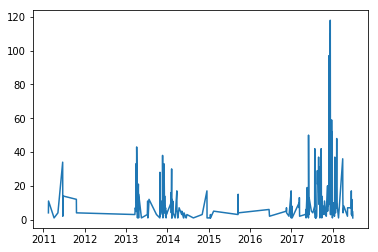

In [24]:
%matplotlib inline
df.time.apply(lambda dt: dt.date()).value_counts().plot()

In [32]:
btc_prices = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20180827", match='Volume', flavor='bs4')
btc_prices = btc_prices[0]
btc_prices['time'] = pd.to_datetime(btc_prices["Date"])
btc_prices.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap,time
0,"Aug 26, 2018",6754.64,6774.75,6620.75,6707.26,3295500000,116387236698,2018-08-26
1,"Aug 25, 2018",6719.95,6789.63,6700.96,6763.19,3312600000,115778181501,2018-08-25
2,"Aug 24, 2018",6551.52,6719.96,6498.64,6719.96,4097820000,112864138781,2018-08-24
3,"Aug 23, 2018",6371.34,6546.54,6371.34,6534.88,3426180000,109748424726,2018-08-23
4,"Aug 22, 2018",6486.25,6816.79,6310.11,6376.71,4668110000,111714827567,2018-08-22


In [54]:
price_vs_post = pd.concat([btc_prices.set_index('time')['Close**'].rename("BTC Close"), 
           df.time.apply(lambda dt: dt.date()).value_counts().rename('n_posts')], axis=1).dropna(subset=['BTC Close']).fillna(0)

In [55]:
price_vs_post.head()

,BTC Close,n_posts
2013-04-28,134.21,0.0
2013-04-29,144.54,0.0
2013-04-30,139.00,0.0
2013-05-01,116.99,0.0
2013-05-02,105.21,0.0


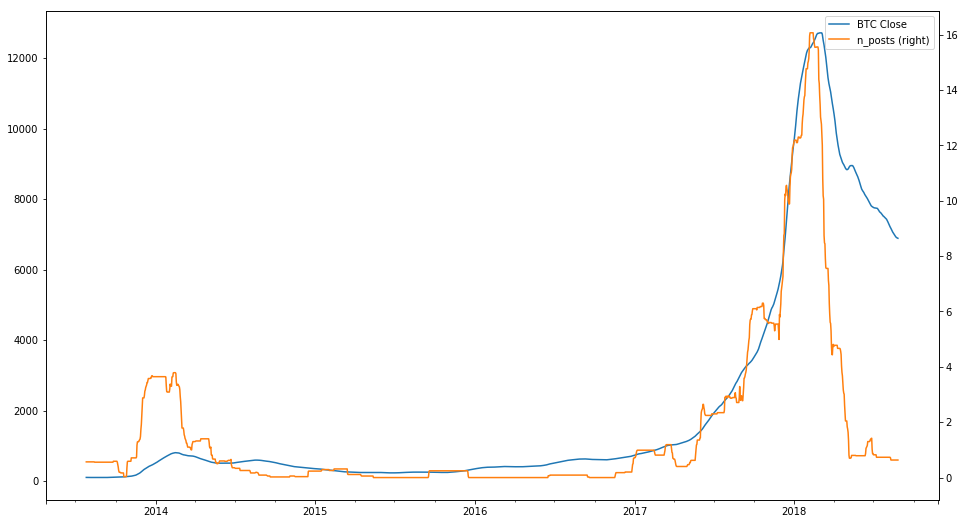

In [66]:
price_vs_post.rolling(90).mean().plot(secondary_y=('n_posts',), figsize=(16, 9))